## Importing Libraries

Sample image size: (512, 512)


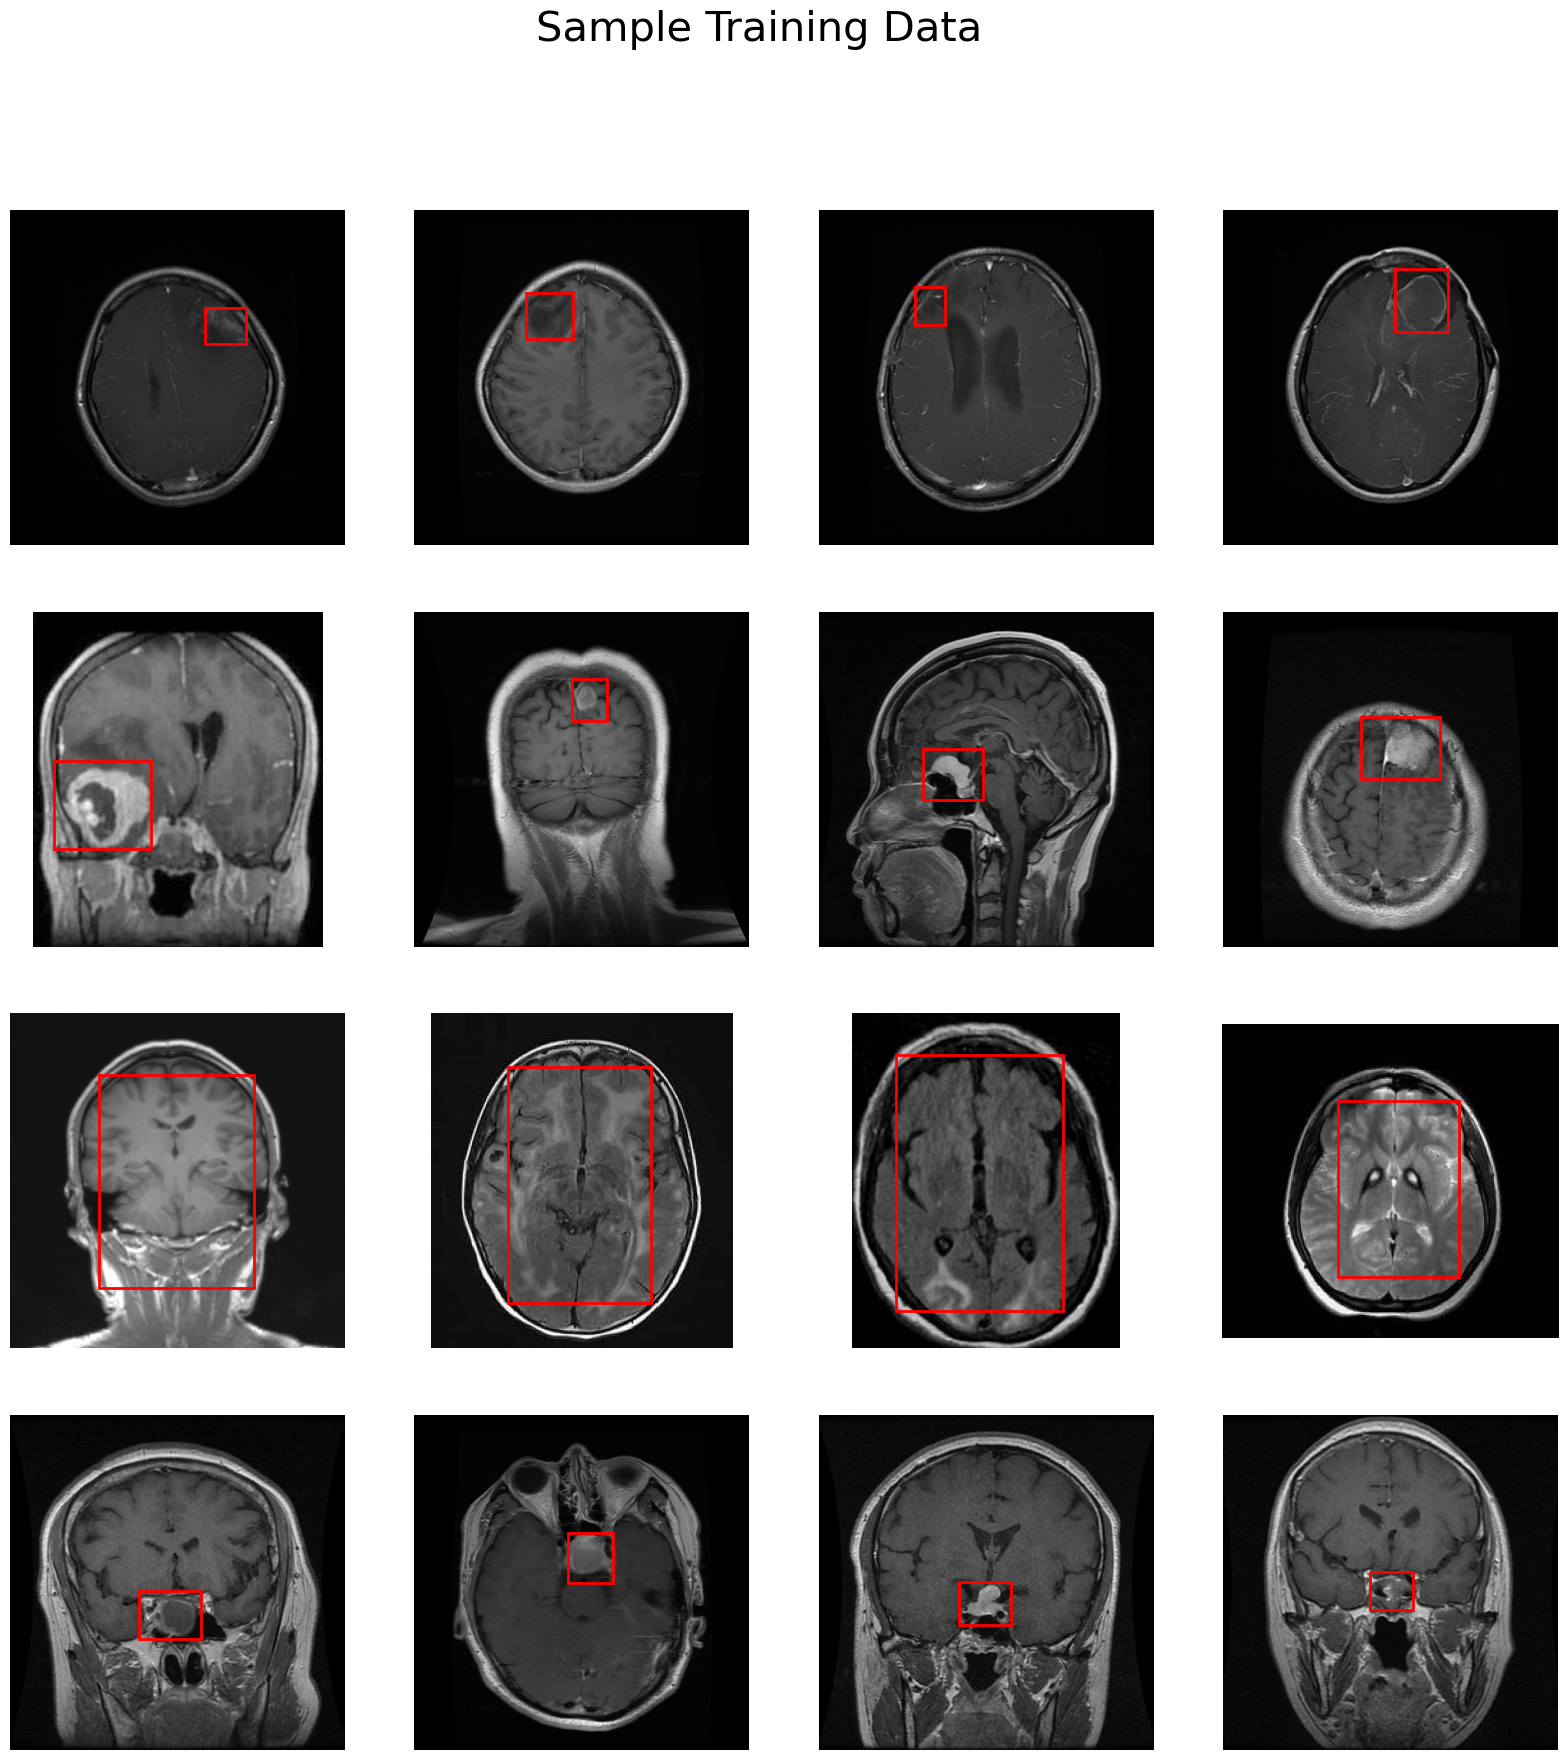

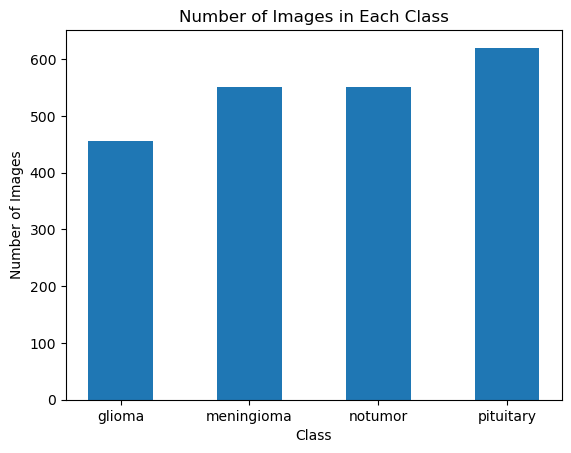

Skipping class 'test' due to insufficient samples.
Skipping class 'train' due to insufficient samples.
Custom train-test split completed.
New https://pypi.org/project/ultralytics/8.3.36 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.34  Python-3.12.7 torch-2.5.1+cpu CPU (AMD Ryzen 5 5500)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=brain_tumor_dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=F

train: Scanning C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\Brain-Tumor-Detection-using-YOLOv8-main\B
val: Scanning C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\Brain-Tumor-Detection-using-YOLOv8-main\Bra


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      3.557      5.435      4.262         34        640:  19%|█▉        | 21/109 [03:34<14:59, 10


KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image

# Set dataset paths (update to match your directory structure)
dataset_directory = r"C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\Brain Tumor labeled dataset"
training_directory = os.path.join(dataset_directory, "Training")
testing_directory = os.path.join(dataset_directory, "Testing")

# Define class labels
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# Load and display a sample image
sample_image_path = os.path.join(dataset_directory, 'meningioma', 'Tr-me_0011.jpg')
sample_image = Image.open(sample_image_path)
print(f"Sample image size: {sample_image.size}")
sample_image.show()

# Plot training data with bounding boxes
def plot_training_data_with_boxes(dataset_directory, class_labels):
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    for class_name, ax_row in zip(class_labels.keys(), axes):
        class_directory = os.path.join(dataset_directory, class_name)
        image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
        selected_images = random.sample(image_files, 4)

        for ax, image_file in zip(ax_row, selected_images):
            annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
            with open(annotation_file, 'r') as file:
                line = file.readline().strip().split()
                class_number, centre_x, centre_y, width, height = map(float, line)

            img = plt.imread(os.path.join(class_directory, image_file))
            if len(img.shape) == 2:  # Handle grayscale images
                img = np.stack((img,) * 3, axis=-1)

            img_height, img_width, _ = img.shape
            x_min = (centre_x - width / 2) * img_width
            y_min = (centre_y - height / 2) * img_height
            x_max = (centre_x + width / 2) * img_width
            y_max = (centre_y + height / 2) * img_height

            tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                           linewidth=2, edgecolor='r', facecolor='none')
            ax.imshow(img)
            ax.add_patch(tumor_bbox)
            ax.axis('off')

    plt.suptitle("Sample Training Data", fontsize=30)
    plt.show()

plot_training_data_with_boxes(dataset_directory, class_labels)

# Bar plot for class distribution
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]
plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

# Custom train-test split function
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None):
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < 2:  # Not enough samples to split
            print(f"Skipping class '{class_dir}' due to insufficient samples.")
            continue

        # Split the data
        train_images, test_images = train_test_split(
            image_files, test_size=test_ratio, random_state=random_seed
        )

        # Copy files to train directory
        for img in train_images:
            src_img = os.path.join(class_path, img)
            dest_img = os.path.join(train_directory, class_dir, img)
            os.makedirs(os.path.dirname(dest_img), exist_ok=True)
            shutil.copy(src_img, dest_img)

            # Copy corresponding annotation file if exists
            src_ann = os.path.join(class_path, img.replace('.jpg', '.txt'))
            if os.path.exists(src_ann):
                dest_ann = os.path.join(train_directory, class_dir, img.replace('.jpg', '.txt'))
                shutil.copy(src_ann, dest_ann)

        # Copy files to test directory
        for img in test_images:
            src_img = os.path.join(class_path, img)
            dest_img = os.path.join(test_directory, class_dir, img)
            os.makedirs(os.path.dirname(dest_img), exist_ok=True)
            shutil.copy(src_img, dest_img)

            # Copy corresponding annotation file if exists
            src_ann = os.path.join(class_path, img.replace('.jpg', '.txt'))
            if os.path.exists(src_ann):
                dest_ann = os.path.join(test_directory, class_dir, img.replace('.jpg', '.txt'))
                shutil.copy(src_ann, dest_ann)

    print("Custom train-test split completed.")


custom_train_test_split(dataset_directory)

# YOLOv8 Training
yolo_btd_model = YOLO('yolov8n.yaml')  # Replace 'yolov8n.yaml' with the correct YOLOv8 configuration
yolo_btd_model.train(data='brain_tumor_dataset.yaml', epochs=1)  # Update paths as needed

# Prediction function
def predict_results(test_dir, model_path, output_dir):
    model = YOLO(model_path)
    os.makedirs(output_dir, exist_ok=True)
    image_files = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]

    for img in image_files:
        img_path = os.path.join(test_dir, img)
        model.predict(img_path, save=True, imgsz=320, conf=0.3)

test_dirs = [
    os.path.join(dataset_directory, 'test', 'glioma'),
    os.path.join(dataset_directory, 'test', 'meningioma'),
    os.path.join(dataset_directory, 'test', 'notumor'),
    os.path.join(dataset_directory, 'test', 'pituitary'),
]

output_dir = r"C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\results"



In [23]:
# Run predictions
for dir in test_dirs:
    predict_results(dir, r'C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\runs\detect\train2\weights\best.pt', output_dir)

# Display inference results
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()



image 1/1 C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\Brain Tumor labeled dataset\test\glioma\Tr-gl_0011.jpg: 320x320 (no detections), 35.1ms
Speed: 1.3ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs\detect\predict9

image 1/1 C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\Brain Tumor labeled dataset\test\glioma\Tr-gl_0022.jpg: 320x320 1 notumor, 34.1ms
Speed: 1.0ms preprocess, 34.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs\detect\predict9

image 1/1 C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\Brain Tumor labeled dataset\test\glioma\Tr-gl_0025.jpg: 320x320 (no detections), 41.5ms
Speed: 0.0ms preprocess, 41.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs\detect\predict9

image 1/1 C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\Brain Tumor labeled dataset\test\glioma\Tr-gl

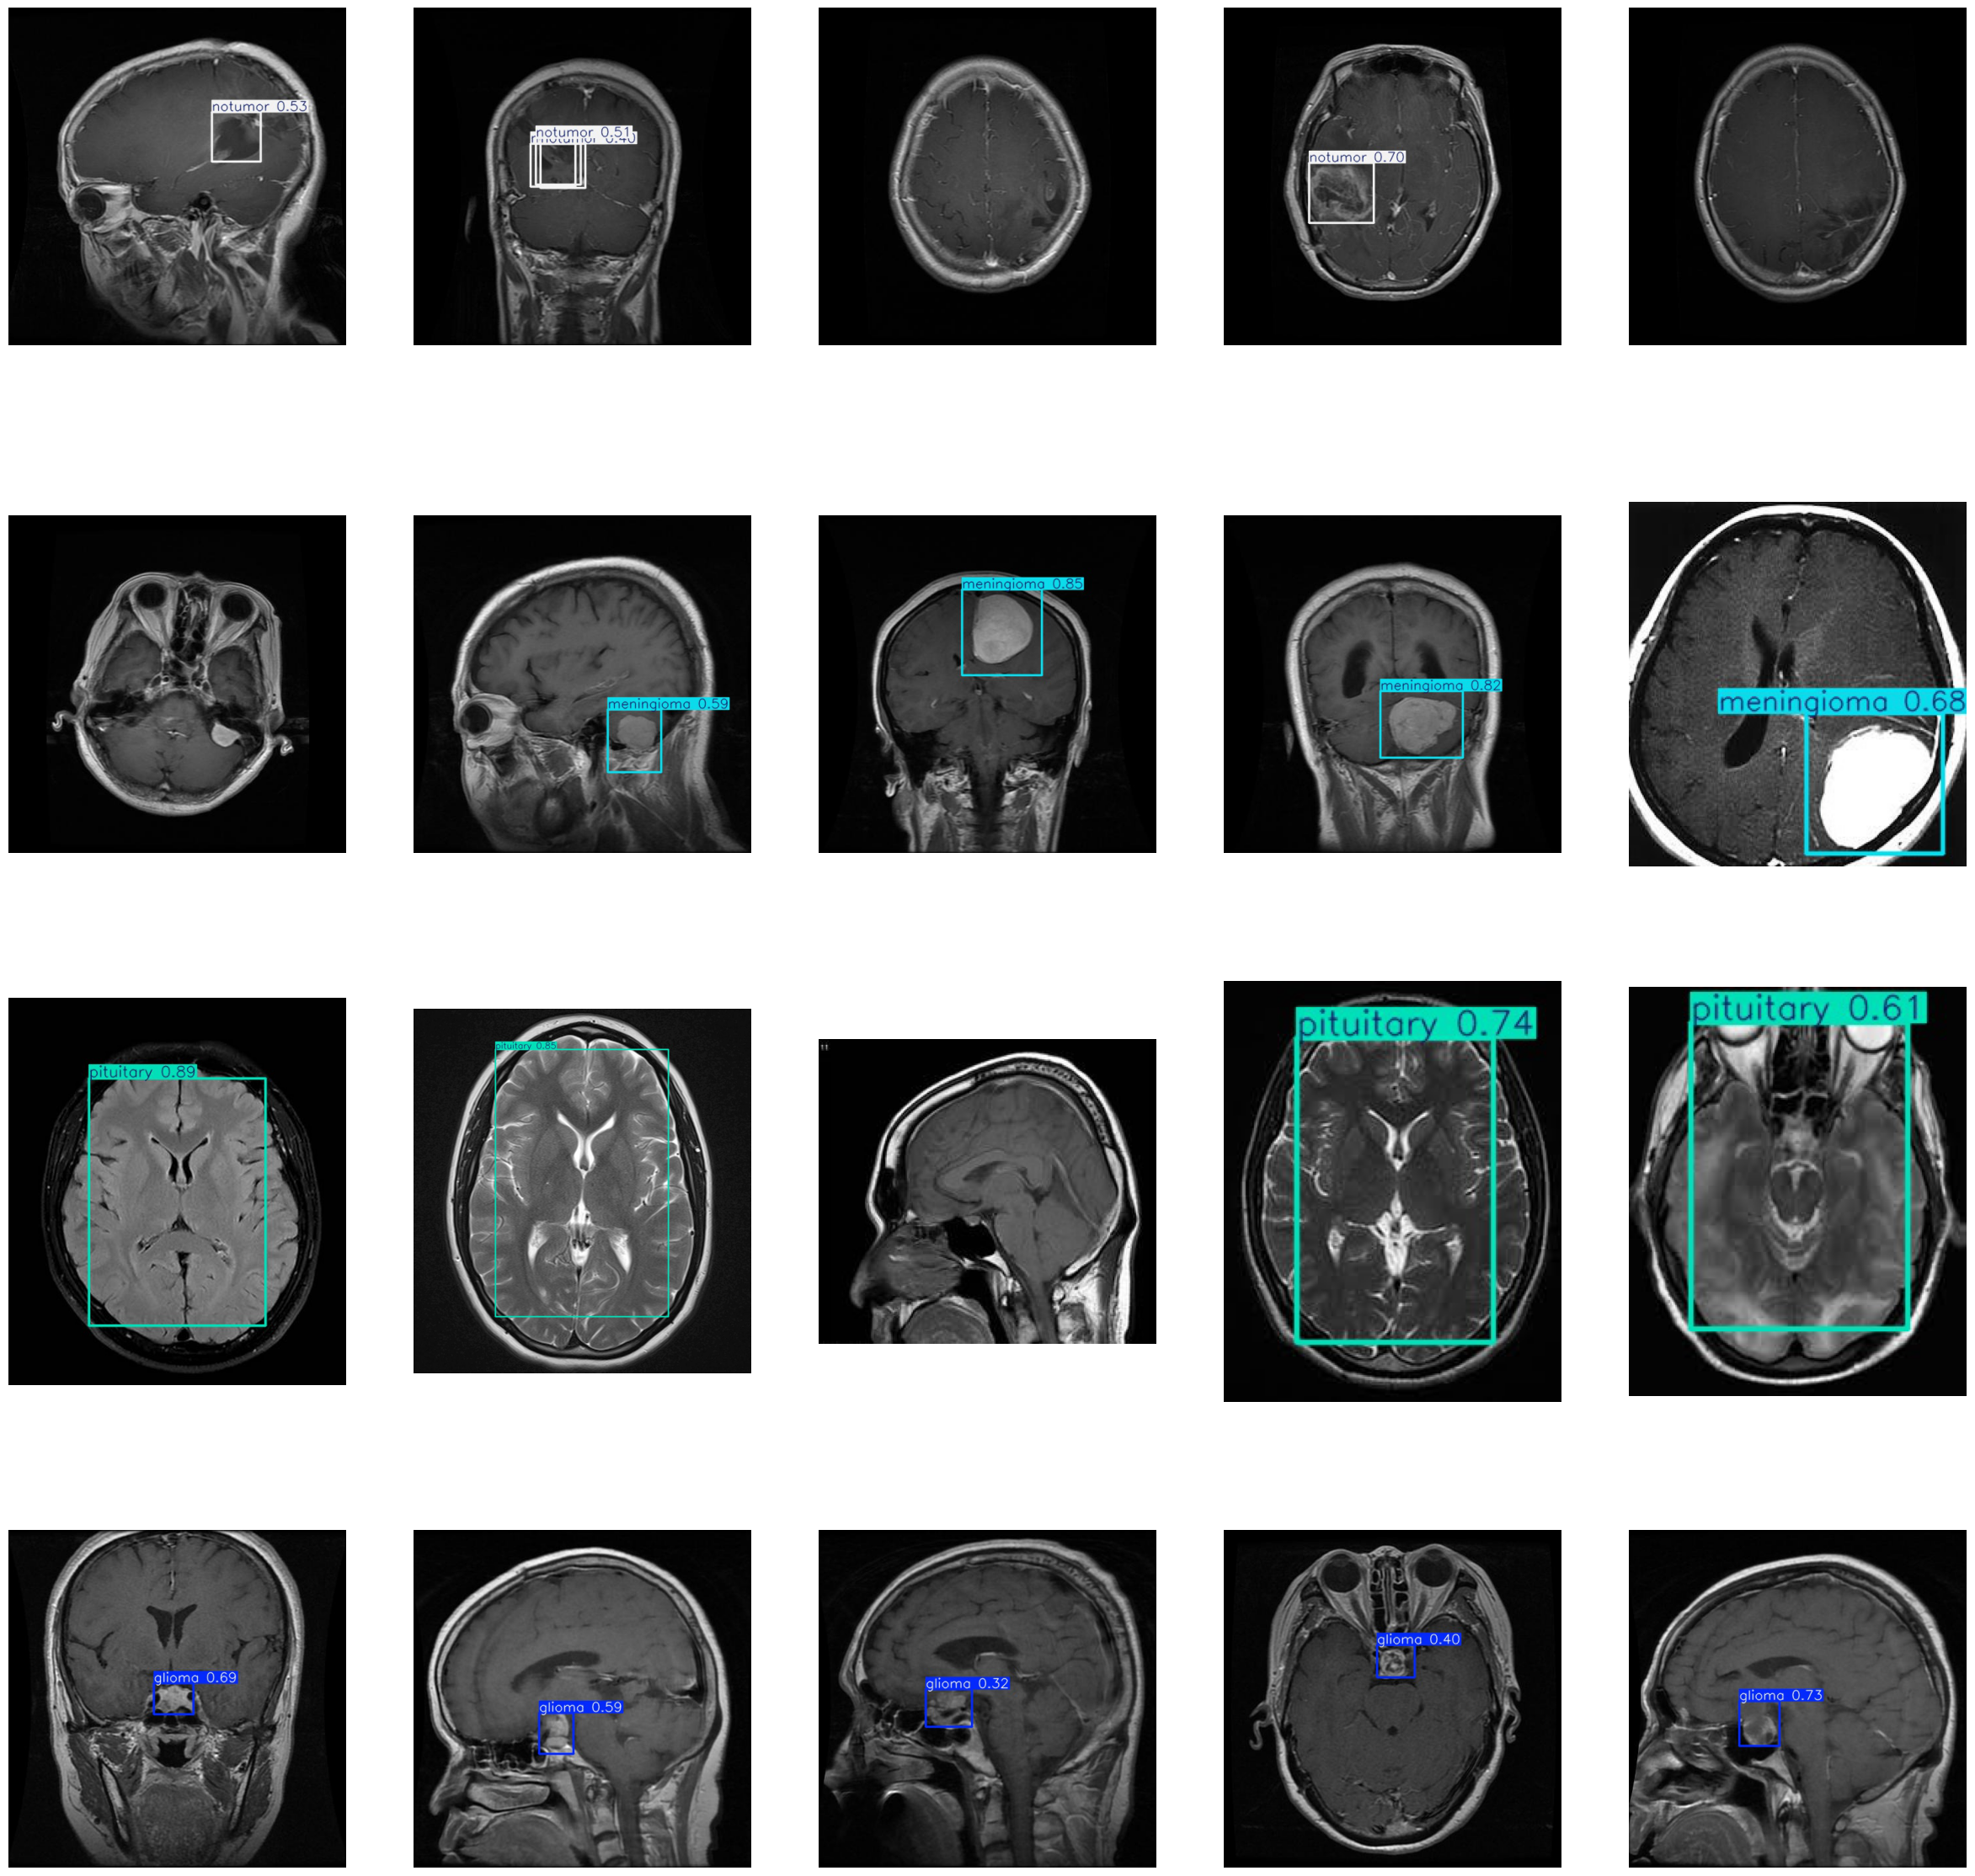

In [24]:
# Adjust paths for inference results
inference_dirs = [
    os.path.join(r'C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\runs\detect', 'predict9'),
    os.path.join(r'C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\runs\detect', 'predict10'),
    os.path.join(r'C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\runs\detect', 'predict11'),
    os.path.join(r'C:\Users\PC\Downloads\Brain-Tumor-Detection-using-YOLOv8-main\runs\detect', 'predict12'),
]

all_images = []
for dir in inference_dirs:
    img_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.jpg')]
    all_images.extend(random.sample(img_files, min(5, len(img_files))))

display_images(all_images)


In [4]:
# Load and display a sample image
sample_image_path = os.path.join(dataset_directory, 'meningioma', 'Tr-pi_0636.jpg')
sample_image = Image.open(sample_image_path)
print(f"Sample image size: {sample_image.size}")
sample_image.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\PC\\Downloads\\Brain-Tumor-Detection-using-YOLOv8-main\\Brain Tumor labeled dataset\\meningioma\\Tr-pi_0636.jpg'